# Plotting and analyzing ASI mosaics

In [55]:
from datetime import datetime
    
import matplotlib.pyplot as plt
import matplotlib.colors
import aacgmv2
import numpy as np
import scipy.interpolate

import asilib
import asilib.asi
import asilib.map

print(f'asilib version: {asilib.__version__}')

asilib version: 0.18.1


We first create an `asilib.Imagers()` object consisting of TREx-RGB `asilib.Imagers()` defined a list of location_codes.

In [2]:
asilib.asi.trex.trex_rgb_info()

,array,location_code,name,latitude,longitude
0,TREx_RGB,ATHA,Athabasca,54.60,-113.64
1,TREx_RGB,FSMI,Fort Smith,60.03,-111.93
2,TREx_RGB,GILL,Gillam,56.38,-94.64
3,TREx_RGB,LUCK,Lucky Lake,51.15,-107.26
4,TREx_RGB,PINA,Pinawa,50.26,-95.87
5,TREx_RGB,RABB,Rabbit Lake,58.23,-103.68


In [13]:
time = datetime(2021, 11, 4, 7, 3, 51)
location_codes = ['FSMI', 'LUCK', 'RABB', 'PINA', 'GILL']
map_alt = 110
min_elevation = 10

In [14]:
_imagers = []

for location_code in location_codes:
    _imagers.append(asilib.asi.trex.trex_rgb(location_code, time=time, alt=map_alt))

asis = asilib.Imagers(_imagers)

Plot a TREx-RGB mosaic with and without AACGM magnetic latitude contours.

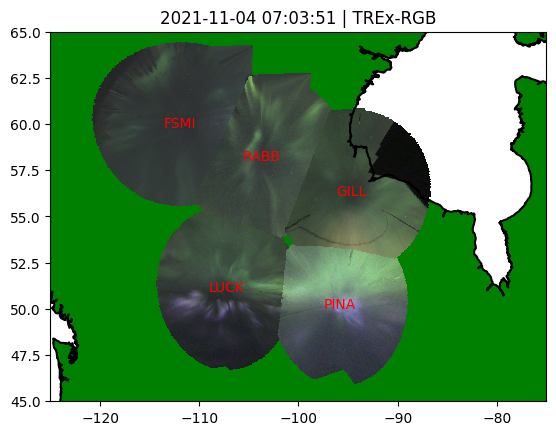

In [50]:
lon_bounds=(-125, -75)
lat_bounds=(45, 65)
ax = asilib.map.create_simple_map(lon_bounds=lon_bounds, lat_bounds=lat_bounds)
asis.plot_map(ax=ax, overlap=False, min_elevation=min_elevation)
plt.title(f'{time} | TREx-RGB');

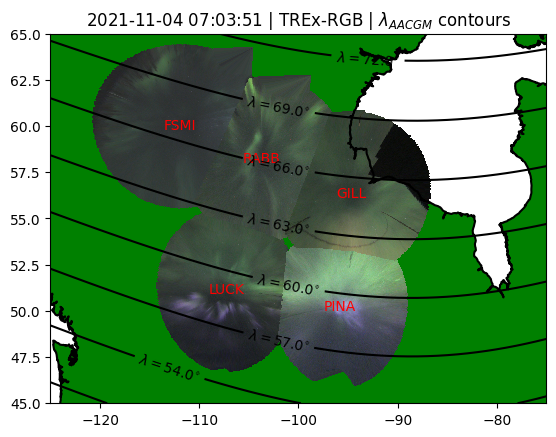

In [68]:
lat_grid, lon_grid = np.meshgrid(np.linspace(*lat_bounds), np.linspace(*lon_bounds, num=51))
# Need to pass flattened arrays since aacgmv2 does not work with n-D arrays.
aacgm_lat_grid, aacgm_lon_grid, _ = aacgmv2.wrapper.convert_latlon_arr(
    lat_grid.flatten(), lon_grid.flatten(), 110, time, method_code='G2A'
    )
aacgm_lat_grid = aacgm_lat_grid.reshape(lat_grid.shape)
aacgm_lon_grid = aacgm_lon_grid.reshape(lon_grid.shape)

ax = asilib.map.create_simple_map(lon_bounds=lon_bounds, lat_bounds=lat_bounds)
asis.plot_map(ax=ax, overlap=False, min_elevation=min_elevation)
cs = plt.contour(lon_grid, lat_grid, aacgm_lat_grid, colors='k')
ax.clabel(cs, inline=True, fontsize=10, fmt=lambda x: f'$\lambda = {{{x}}}^{{\circ}}$')
plt.title(f'{time} | TREx-RGB | $\lambda_{{AACGM}}$ contours');

Now lets try to put the mosaic onto a custom grid.

In [78]:
lat_lon_points, intensities = asis.get_points(min_elevation=min_elevation)
lat_grid2, lon_grid2 = np.meshgrid(np.linspace(*lat_bounds, num=100), np.linspace(*lon_bounds, num=101))
rgb_grid = scipy.interpolate.griddata(lat_lon_points, intensities, (lat_grid2, lon_grid2), method='cubic')
g_grid = scipy.interpolate.griddata(lat_lon_points, intensities[:, 1], (lat_grid2, lon_grid2), method='cubic')
b_grid = scipy.interpolate.griddata(lat_lon_points, intensities[:, 2], (lat_grid2, lon_grid2), method='cubic')

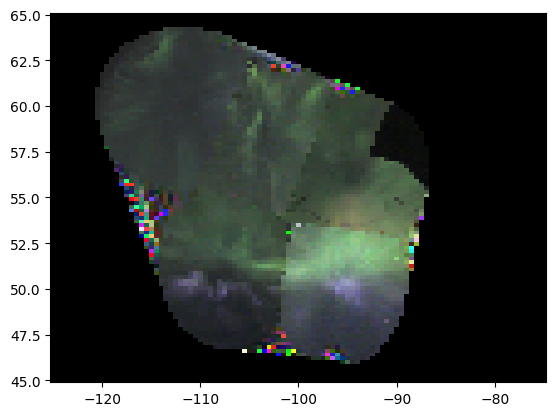

In [81]:
plt.pcolormesh(lon_grid2, lat_grid2, rgb_grid/255)  # Need to divide by 255 to indicate RGB channels to pcolormesh.

Looks good enough for a 100x101 grid! Now, how about the individual colors and green-blue ratio?

First, the blue grid:

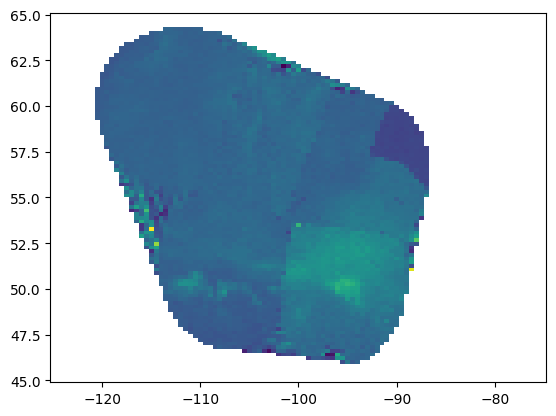

In [86]:
plt.pcolormesh(lon_grid2, lat_grid2, b_grid)

And the green grid:

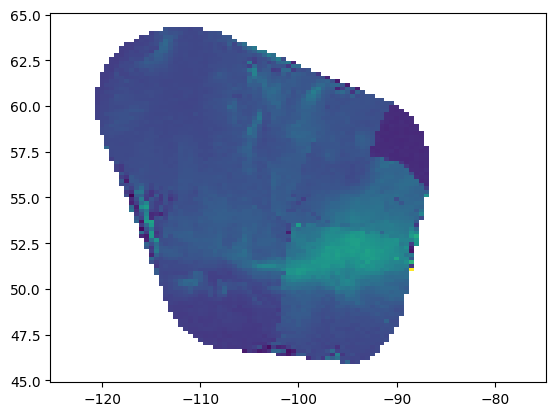

In [87]:
plt.pcolormesh(lon_grid2, lat_grid2, g_grid)

And the ratio:

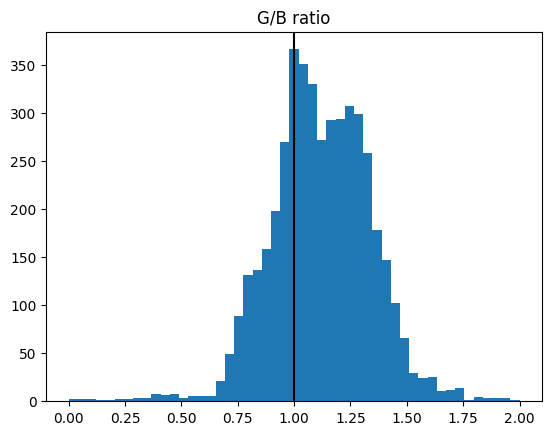

In [102]:
plt.hist((g_grid/b_grid).flatten(), bins=np.linspace(0, 2));
plt.title('G/B ratio')
plt.axvline(1, c='k')

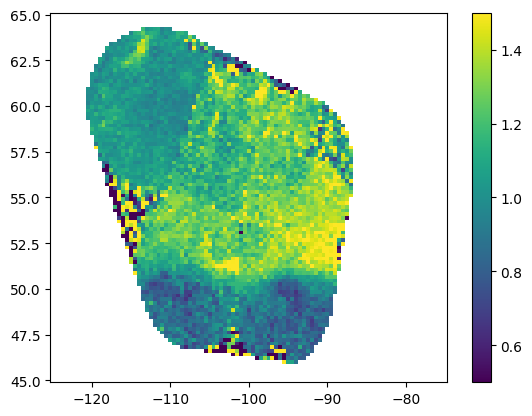

In [116]:
plt.pcolormesh(lon_grid2, lat_grid2, g_grid/b_grid, vmin=0.5, vmax=1.5)
plt.colorbar()

Normalized ratio

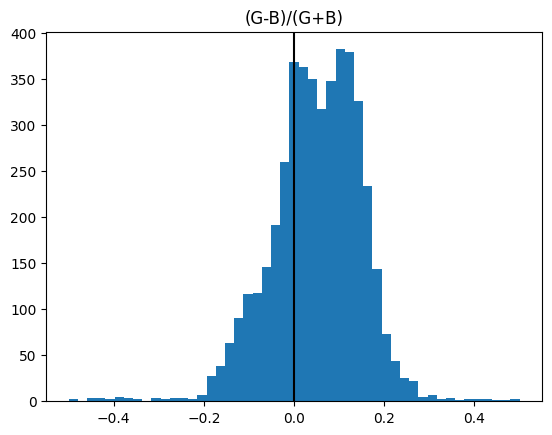

In [113]:
plt.hist(((g_grid-b_grid)/(g_grid+b_grid)).flatten(), bins=np.linspace(-0.5, 0.5));
plt.title('(G-B)/(G+B)')
plt.axvline(0, c='k')

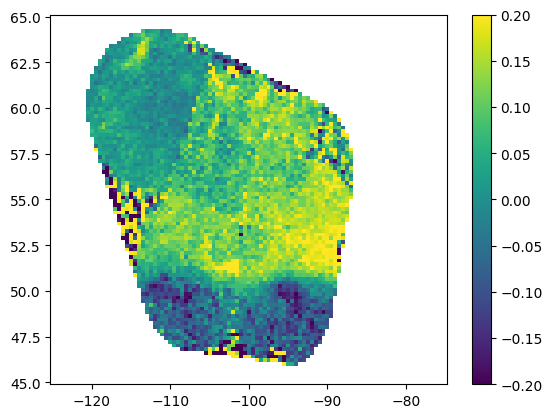

In [119]:
plt.pcolormesh(lon_grid2, lat_grid2, (g_grid-b_grid)/(g_grid+b_grid), vmin=-0.2, vmax=0.2)
plt.colorbar()